In [30]:
# Importing libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [31]:
# Part 1

# Task 1
# column names for dataframe
columns = ['title', 'total_time', 'image', 'ingredients', 'rating_val', 'rating_count', 'category', 'cuisine', 'diet',
           'vegan', 'vegetarian', 'url']

# function to collect data from the URL
def collect_page_data(url):
    try:
        # GET request to fetch from webpage
        page = requests.get(url)
        page.encoding = page.apparent_encoding
        soup = BeautifulSoup(page.text, 'html.parser')
        
        # extract recipe name
        recipe_name = soup.find('title').get_text(strip=True)

        # loop through JSON to get relevant data
        for script in soup.find_all("script", type="application/ld+json"):
            res = json.loads(script.contents[0])

            # look inside @graph key
            for item in res['@graph']:
                if item.get('@type') == 'Recipe': # checking if item is a 'Recipe'

                    # gettings image, ingredients, ratings, category and cuisine
                    image = item.get('image').get("url") if item.get('image').get("url") else "Unknown"
                    ingredients = ', '.join(item.get('recipeIngredient')) if item.get('recipeIngredient') else "Unknown"
                    rating_val = item.get('aggregateRating').get('ratingValue') if item.get('aggregateRating').get('ratingValue') else 0
                    rating_count = item.get('aggregateRating').get('ratingCount') if item.get('aggregateRating').get('ratingCount') else 0
                    category = item.get('recipeCategory') if item.get('recipeCategory') else "Unknown"
                    cuisine = item.get('recipeCuisine') if item.get('recipeCuisine') else "Unknown"

        # getting the total time
        total_time = soup.find("dl", class_="ssrcss-160xqny-Wrapper e85aajs0")

        if total_time:
            time_list = [t for t in total_time.find_all(string=lambda t: "mins" in t)]
            total_time = f"Prep: {time_list[0]}; Cook: {time_list[1]}" if len(time_list) >= 2 else 0
        else:
            total_time = 0

        # diet info
        diet_section = soup.find("dl", class_="ssrcss-160xqny-Wrapper e85aajs0")
        diet = [d.text for d in diet_section.find_all("a")] if diet_section else ["Unknown"]
        diet = ", ".join(diet) if diet else "Unknown"
        
        # check for vegan or vegetarian
        vegan = 'vegan' in diet.lower()
        vegetarian = 'vegetarian' in diet.lower()
        
        # dictionary to store extracted data
        data = {
            'title': recipe_name,
            'total_time': total_time,
            'image': image,
            'ingredients': ingredients,
            'rating_val': rating_val,
            'rating_count': rating_count,
            'category': category,
            'cuisine': cuisine,
            'diet': diet,
            'vegan': vegan,
            'vegetarian': vegetarian,
            'url': url
        }

        # making a dataframe
        df = pd.DataFrame([data], columns=columns)
        return df
    except:
        print("Website does not contain an recipe")


# urls for testing
urls = [
    "https://www.bbc.co.uk/food/recipes/easiest_ever_banana_cake_42108",
    "https://www.bbc.co.uk/food/recipes/avocado_pasta_with_peas_31700",
    "https://www.bbc.co.uk/food/recipes/easy_chocolate_cake_31070",
    "https://www.bbc.co.uk/food/recipes/mattar_paneer_38293"
]

# loop through each url and put it as a list
data = []
for url in urls:
    df = collect_page_data(url)
    if df is not None:
        display(df)
        data.append(df)

,title,total_time,image,ingredients,rating_val,rating_count,category,cuisine,diet,vegan,vegetarian,url
0,Easy banana cake recipe - BBC Food,Prep: less than 30 mins; Cook: 30 mins to 1 hour,https://ichef.bbci.co.uk/food/ic/food_16x9_160...,3 very ripe medium bananas (around 225g/8oz pe...,4.484914,464,Cakes and baking,British,"Nut-free, Pregnancy-friendly, Vegetarian",False,True,https://www.bbc.co.uk/food/recipes/easiest_eve...


,title,total_time,image,ingredients,rating_val,rating_count,category,cuisine,diet,vegan,vegetarian,url
0,Avocado pasta recipe - BBC Food,Prep: less than 30 mins; Cook: less than 10 mins,https://ichef.bbci.co.uk/food/ic/food_16x9_160...,"375g/13oz pasta, such as penne or fusilli, 1 l...",4,37,Main course,Unknown,"Dairy-free, Egg-free, Healthy, Nut-free, Pregn...",True,True,https://www.bbc.co.uk/food/recipes/avocado_pas...


,title,total_time,image,ingredients,rating_val,rating_count,category,cuisine,diet,vegan,vegetarian,url
0,Easy chocolate cake recipe - BBC Food,Prep: less than 30 mins; Cook: 30 mins to 1 hour,https://ichef.bbci.co.uk/food/ic/food_16x9_160...,"225g/8oz plain flour, 350g/12½oz caster sugar,...",3.725453,1599,Cakes and baking,Unknown,"Nut-free, Pregnancy-friendly, Vegetarian",False,True,https://www.bbc.co.uk/food/recipes/easy_chocol...


,title,total_time,image,ingredients,rating_val,rating_count,category,cuisine,diet,vegan,vegetarian,url
0,Matar paneer recipe - BBC Food,Prep: less than 30 mins; Cook: 30 mins to 1 hour,https://ichef.bbci.co.uk/food/ic/food_16x9_160...,"vegetable oil, for shallow frying, 450g/1lb pa...",4.764706,17,Main course,Indian,"Egg-free, Nut-free, Pregnancy-friendly, Vegeta...",False,True,https://www.bbc.co.uk/food/recipes/mattar_pane...


In [32]:
# Task 2

# putting the dataframe into a csv file
result = pd.concat(data, ignore_index=True)
result.to_csv('recipes_task1.csv', index=False, encoding='utf-8-sig')

In [33]:
# Part 2

# Task 1

# getting the csv file
filename = 'recipes.csv'
df = pd.read_csv(filename)

# prints the number of missing values in each column
print(f'Null:\n\n{df.isnull().sum()}') 

# since cusine is the only column with missing values we replace them with Unknown
df.replace(" ", "Unknown", inplace=True)

# summary statistic
summary = df.describe()
print("\nSummary Statistic:")
display(summary)

# top 10 in terms of highest rated using rating_avg
top_10 = df.nlargest(10, 'rating_avg')[['title', 'rating_avg', 'rating_val']]
print("\n10 Highest Rated:")
display(top_10)

Null:

Unnamed: 0     0
id             0
title          0
image_url      0
recipe_url     0
rating_avg     0
rating_val     0
total_time     0
category       0
cuisine        0
ingredients    0
dtype: int64

Summary Statistic:


,Unnamed: 0,id,rating_avg,rating_val,total_time
count,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000
mean,1646.000000,1647.000000,4.497432,12.038567,127.227452
std,950.751545,950.751545,0.611602,25.221305,156.363779
min,0.000000,1.000000,1.000000,1.000000,30.000000
25%,823.000000,824.000000,4.250000,3.000000,60.000000
50%,1646.000000,1647.000000,4.666667,6.000000,90.000000
75%,2469.000000,2470.000000,5.000000,13.000000,150.000000
max,3292.000000,3293.000000,5.000000,776.000000,840.000000



10 Highest Rated:


,title,rating_avg,rating_val
1,Adaptable bean soup,5.0,11
4,All-day breakfast frittata,5.0,10
5,All-in-one turkey,5.0,3
10,Aloo gobi and jeera rice,5.0,12
11,Alpine pizza,5.0,7
13,American baked cheesecake,5.0,1
14,Anchovy and sage crisps,5.0,1
16,Angel food cake with lemon curd,5.0,4
19,Apple and passion fruit tartlets,5.0,1
22,Apple and rhubarb muffins,5.0,4


In [34]:
# Task 2

# grouping by average rating and number of rating value
average_ratings = df.groupby('title', as_index=False).agg({
    'rating_avg': 'mean',  # Average rating per recipe
    'rating_val': 'sum'    # Total number of ratings per recipe
})

# sorting by rating average and rating value
average_ratings_sorted = average_ratings.sort_values(['rating_avg', 'rating_val'], ascending=[False, False])

# display the top 10 highest rated recipes
print("Top 10 Recipes by Average Rating & Rating Value:")
display(average_ratings_sorted.head(10))

# get the overall average rating
average = average_ratings['rating_avg'].mean()
print(f"\nOverall Average Rating: {average}")

# defining bootstrap samples and a list to store them in
num_bootstrap_samples = 1000
sample_size = 100
bootstrap_samples = []

# looping through each bootstrap sample and calculating mean for rating_avg
for _ in range(num_bootstrap_samples):
    sample = average_ratings.sample(sample_size, replace=True) # can use same sample again
    bootstrap_samples.append(sample['rating_avg'].mean())

# calculating 2.5th - 97.5th percentiles -- 95% confidence level
lower_bound, upper_bound = np.percentile(bootstrap_samples, [2.5, 97.5])

# printing them out
print(f"\nBootstrap Means Values: {bootstrap_samples}")
print(f"\n95% Confidence Interval: {lower_bound} - {upper_bound}")

Top 10 Recipes by Average Rating & Rating Value:


,title,rating_avg,rating_val
1432,How to cook the perfect omelette,5.0,29
868,"Creamy chilli, bacon and tomato spaghetti",5.0,26
1266,Greek salad,5.0,26
2968,Teriyaki salmon,5.0,26
3070,Tuna pasta sauce,5.0,26
619,Chilli-fried tofu with egg-fried rice,5.0,24
1192,"Gemelli with anchovies, tomatoes and mascarpone",5.0,23
115,Baked salmon with parmesan and parsley crust,5.0,22
398,Carrot and sultana cake with creamy orange fro...,5.0,22
1734,Make-ahead sticky toffee pudding,5.0,22



Overall Average Rating: 4.497476218124277

Bootstrap Means Values: [4.40021465443, 4.419616555799999, 4.508494114274999, 4.5688033384099995, 4.51406884745, 4.499327743159999, 4.54172041521, 4.45848586766, 4.41499156047, 4.61237053262, 4.433851673235001, 4.59202448826, 4.458389484895, 4.39200269955, 4.5400115336799995, 4.49835672265, 4.525265078035, 4.498940381480001, 4.522911780619999, 4.5060908152, 4.45609781963, 4.530839944285001, 4.42851711959, 4.54890337738, 4.48058983763, 4.487068239449999, 4.59010944825, 4.566730715335, 4.562877032015, 4.47504473262, 4.51556429967, 4.544843203705001, 4.555022784249999, 4.59743386513, 4.33317811672, 4.51998049762, 4.41243606092, 4.524245807115, 4.44895345996, 4.424793151509999, 4.572371659209999, 4.558531166135001, 4.395125971950001, 4.5920272204899995, 4.436647649165, 4.40778928476, 4.52334759156, 4.3710420583400005, 4.434992174625, 4.6052337225999995, 4.521115607784999, 4.4238361649749995, 4.5249831792399995, 4.357393318300001, 4.38753892769499

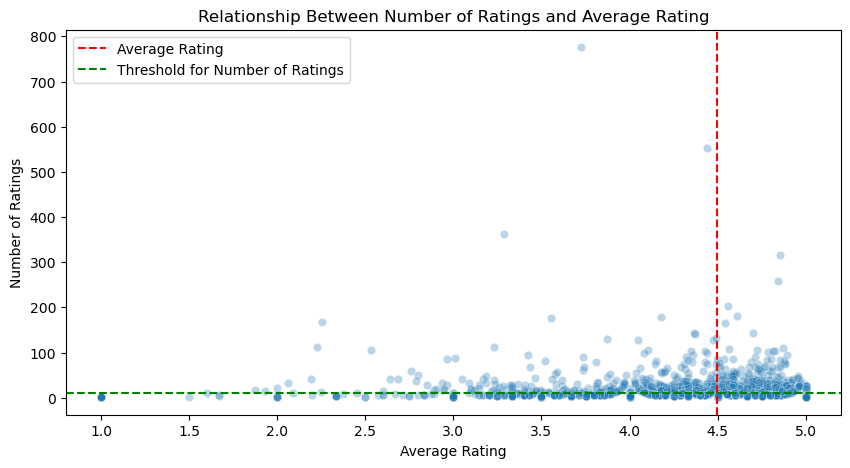

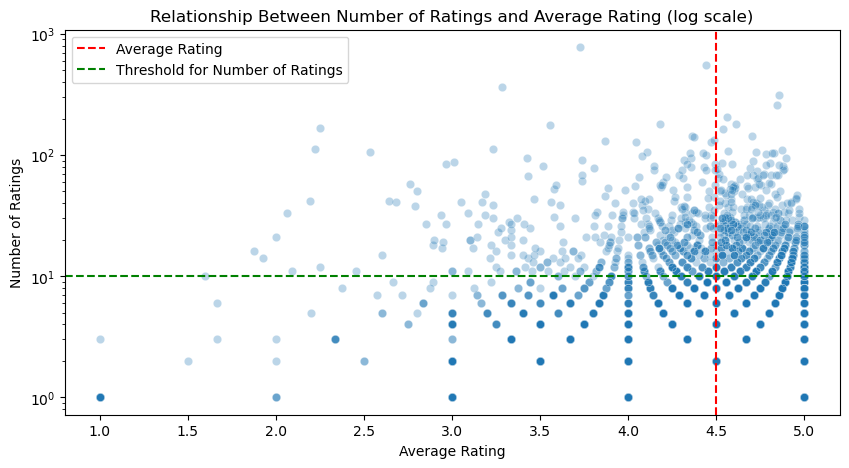

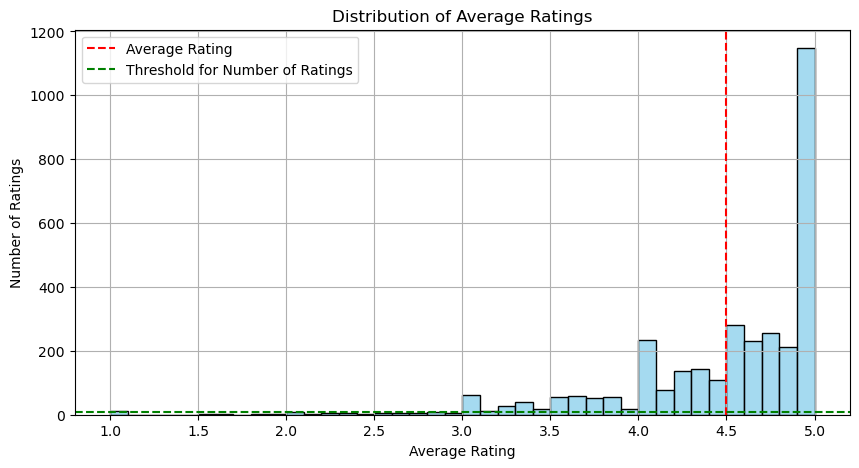

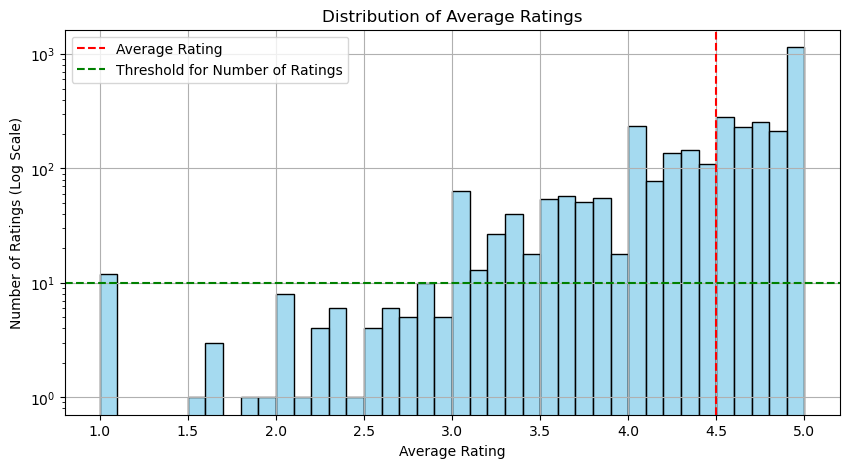

In [35]:
# Task 3

# Scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='rating_avg', y='rating_val', alpha=0.3)
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Relationship Between Number of Ratings and Average Rating")
plt.axvline(x=average, color='r', linestyle='--', label="Average Rating")
plt.axhline(y = 10, color = 'g', linestyle = '--', label = "Threshold for Number of Ratings")
plt.legend()
plt.show()

# Scatter plot (log scale)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='rating_avg', y='rating_val', alpha=0.3)
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Relationship Between Number of Ratings and Average Rating (log scale)")
plt.axvline(x=average, color='r', linestyle='--', label="Average Rating")
plt.axhline(y = 10, color = 'g', linestyle = '--', label = "Threshold for Number of Ratings")
plt.yscale("log")
plt.legend()
plt.show()

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['rating_avg'], bins='auto', color='skyblue', edgecolor="black")
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Average Ratings")
plt.axvline(x=average, color='r', linestyle='--', label="Average Rating")
plt.axhline(y = 10, color = 'g', linestyle = '--', label = "Threshold for Number of Ratings")
plt.legend()
plt.grid(True)
plt.show()

# Histogram (log scale)
plt.figure(figsize=(10, 5))
sns.histplot(df['rating_avg'], bins='auto', color='skyblue', edgecolor="black")
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings (Log Scale)")
plt.title("Distribution of Average Ratings")
plt.axvline(x=average, color='r', linestyle='--', label="Average Rating")
plt.axhline(y=10, color='g', linestyle='--', label="Threshold for Number of Ratings")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

The average rating is very high at 4.5 because of the majority of average ratings are being between 4.0 and 5.0.

The data is right skewed because a there is a clear spike and concentration between rating values of 4.0 and 5.0.

The data also suggests that high rating value tends to have a higher and more stable rating around the average of 4.5.

The data also shows inconsistent pattern especially with low rating values. Hence we decided to have a threshold at rating value 10. This helps in reducing unreliable ratings.

In [36]:
# Task 4a

# defining the features list and combine to make a single string
features = ["title", "rating_avg", "rating_val", "total_time", "category", "cuisine", "ingredients"]
df["combine_features"] = df[features].astype(str).agg(" ".join, axis = 1)

In [37]:
# Task 4b

# initialising CountVectorizer
vectoriser = CountVectorizer(stop_words="english")
matrix = vectoriser.fit_transform(df["combine_features"]) # creating a matrix
cos_similarity = cosine_similarity(matrix) # finding similarity using cosine angle

# printing them
print("Cosine Similarity Matrix:")
display(pd.DataFrame(cos_similarity, index=df["title"], columns=df["title"]))

Cosine Similarity Matrix:


title,A classic sponge cake,Adaptable bean soup,Affogato,Albanian baked lamb with rice (Tavë kosi),All-day breakfast frittata,All-in-one turkey,All-in-one white sauce,Almond lentil stew,Almond tart,Aloo gobi,...,Ox cheek massaman curry,Oxtail soup,Oxtail soup with mini parsley dumplings,Oxtail stew,Pumpkin stew with sour cream,"Pumpkin, chilli and coconut soup",Punjabi chicken curry,Puy lentil lasagne,Pytt i panna,Quinoa salad with mint and mango
title,,,,,,,,,,,,,,,,,,,,,
A classic sponge cake,1.000000,0.036418,0.000000,0.100901,0.089984,0.122513,0.186052,0.068279,0.392232,0.078446,...,0.057213,0.037062,0.119630,0.035223,0.113228,0.000000,0.065372,0.125615,0.085592,0.000000
Adaptable bean soup,0.036418,1.000000,0.000000,0.127386,0.255609,0.203005,0.234888,0.290929,0.000000,0.148556,...,0.108346,0.386024,0.339819,0.333519,0.214423,0.310345,0.154746,0.267615,0.202610,0.113715
Affogato,0.000000,0.000000,1.000000,0.000000,0.000000,0.055216,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.136083,0.000000,0.000000,0.056614,0.000000,0.000000
Albanian baked lamb with rice (Tavë kosi),0.100901,0.127386,0.000000,1.000000,0.236067,0.267836,0.271163,0.149270,0.171499,0.205798,...,0.225141,0.259281,0.261533,0.246416,0.132020,0.127386,0.171499,0.274618,0.187120,0.140028
All-day breakfast frittata,0.089984,0.255609,0.000000,0.236067,1.000000,0.214972,0.290191,0.319489,0.057354,0.275299,...,0.133855,0.216777,0.174928,0.206021,0.176604,0.213007,0.152944,0.330623,0.400501,0.187317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Pumpkin, chilli and coconut soup",0.000000,0.310345,0.000000,0.127386,0.213007,0.174004,0.293610,0.096976,0.046424,0.297113,...,0.216692,0.245652,0.226546,0.233463,0.142948,1.000000,0.154746,0.178410,0.162088,0.037905
Punjabi chicken curry,0.065372,0.154746,0.000000,0.171499,0.152944,0.260290,0.052705,0.261116,0.000000,0.533333,...,0.364662,0.188982,0.203331,0.209540,0.224525,0.154746,1.000000,0.213504,0.181848,0.136083
Puy lentil lasagne,0.125615,0.267615,0.056614,0.274618,0.330623,0.325102,0.354459,0.390246,0.160128,0.288231,...,0.186857,0.302614,0.268612,0.287599,0.338983,0.178410,0.213504,1.000000,0.244600,0.163430


In [38]:
# Task 4c

# getting the recipe and it's index
recipe_title = 'Chicken and coconut curry'
recipe_index = df[df['title'] == recipe_title].index[0]

# getting cosine similarity scores for that title and creating a dataframe which is sorted in descending order
similarity_scores = cos_similarity[recipe_index]
similarity_df = pd.DataFrame(similarity_scores, index=df['title'], columns=['similarity'])
sorted_similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

# showing only the top 10 - itself
top_10_recommendations = sorted_similarity_df.iloc[1:11]

# printing it
print(f"Top 10 Recommendations for {recipe_title}:")
display(top_10_recommendations)

Top 10 Recommendations for Chicken and coconut curry:


,similarity
title,
Vegan blackeye bean curry,0.741941
Leftover chicken curry,0.654846
Indian fish curry,0.653537
Jamaican chicken curry,0.653537
Chicken curry (shorshe murgi),0.650987
Chicken curry with basmati rice,0.642364
Simple chicken curry,0.615457
Chicken and vegetable balti,0.598764
Goan fish curry,0.597614


In [39]:
# Part 3
# Task 1

# defining vector space method
def vec_space_method(recipe_title):
    # initialising CountVectorizer and creating a matrix
    vectorizer = CountVectorizer(stop_words="english")
    matrix = vectorizer.fit_transform(df["combine_features"])

    # allows partial matches in titles
    recipe_title = df[df["title"].str.contains(recipe_title, case=False, na=False)]["title"].iloc[0]

    # getting the index of recipe
    recipe_index = df[df["title"] == recipe_title].index[0]

    # get target vector and reshape it
    target_vector = matrix[recipe_index]
    target_vector = target_vector.reshape(1, -1)

    # calculate cosine similarity between target and others
    similarity_scores = cosine_similarity(matrix, target_vector).flatten()

    # create dataframe for sorting and show the top 10 - itself
    similarity_df = pd.DataFrame(similarity_scores, index=df["title"], columns=["similarity"])
    sorted_similarity_df = similarity_df.sort_values(by="similarity", ascending=False)

    return sorted_similarity_df.iloc[1:11]

# test function for a recipe
vec_space_method("chicken and coconut curry")

,similarity
title,
Vegan blackeye bean curry,0.741941
Leftover chicken curry,0.654846
Indian fish curry,0.653537
Jamaican chicken curry,0.653537
Chicken curry (shorshe murgi),0.650987
Chicken curry with basmati rice,0.642364
Simple chicken curry,0.615457
Chicken and vegetable balti,0.598764
Goan fish curry,0.597614


In [40]:
# Task 2

# defining KNN
def knn_similarity(recipe):
    recipes = csr_matrix(matrix)

    # initialise KNN model
    knn = NearestNeighbors(metric="euclidean", algorithm="auto", n_neighbors=51, n_jobs=-1)
    knn.fit(recipes)

    # allow partial matches in titles
    recipe = df[df["title"].str.contains(recipe, case=False, na=False)]["title"].iloc[0]

    # find the index of the given recipe
    query_idx = df[df["title"] == recipe].index[0]

    # get the vector for the given recipe
    pt_of_interest = recipes[query_idx, :]

    # find the nearest neighbors -- 11 but 10 - itself
    dist, idx = knn.kneighbors(pt_of_interest, n_neighbors=11)

    # create a similarity DataFrame
    recommendations = {
        "title": df.iloc[idx.flatten()[1:]]["title"].values,  # skip itself
        "similarity": 1 / (1 + dist.flatten()[1:])  # convert distance to similarity
    }

    # put the values in a dataframe
    similarity_df = pd.DataFrame(recommendations).set_index("title")

    # sort the values in descending order
    similarity_df = similarity_df.sort_values(by="similarity", ascending=False)

    return similarity_df

# test with recipe
knn_similarity("chicken and coconut curry")

,similarity
title,
Vegan blackeye bean curry,0.169521
Leftover chicken curry,0.154387
Chicken curry (shorshe murgi),0.152259
Chicken curry with basmati rice,0.150221
Simple chicken curry,0.148268
Jamaican chicken curry,0.148268
Chicken and vegetable balti,0.148268
Indian fish curry,0.148268
Goan fish curry,0.144591


In [41]:
# Task 3

# set of users and their liked recipes
test_users = {
    "User 1": "Chicken tikka masala",
    "User 2": "Albanian baked lamb with rice",
    "User 3": "Baked salmon with chorizo rice",
    "User 4": "Almond lentil stew",
}


# defining coverage
def coverage(recommender_func, test_users, top_k=10):
    all_recs = set() # set to store all recommended recipes
    for user, recipe in test_users.items():
        recs = recommender_func(recipe).head(top_k).index.tolist() # getting top recommendations
        all_recs.update(recs) # adding to the set
    coverage = len(all_recs) / len(df) # coverage = unique recommended / total in dataset
    return coverage

# defining personalisation
def personalisation(recommender_func, test_users, top_k=10):
    user_recs = {}  # dictionary to store recommended recipes
    for user, recipe in test_users.items():
        recs = recommender_func(recipe).head(top_k).index.tolist()  # getting the top recommended recipes
        user_recs[user] = set(recs)  # storing it into the dictionary

    cosine_sims = []  # list to store cosine similarity between users
    users = list(user_recs.keys())  # list of users
    for i in range(len(users)):
        for j in range(i + 1, len(users)):  # going through each pair of users
            set_a = user_recs[users[i]]  # recommendations for user i
            set_b = user_recs[users[j]]  # recommendations for user j

            # convert sets to binary vectors (1 for recommended, 0 for not recommended)
            vector_a = [1 if recipe in set_a else 0 for recipe in df['title']]
            vector_b = [1 if recipe in set_b else 0 for recipe in df['title']]

            # calculate cosine similarity between the two vectors
            sim = cosine_similarity([vector_a], [vector_b])[0][0]
            cosine_sims.append(sim)  # store the cosine similarity

    # personalisation = 1 - average cosine similarity
    personalisation = 1 - np.mean(cosine_sims)
    return personalisation

# evaluate KNN
print("KNN Recommender:")
knn_coverage = coverage(knn_similarity, test_users)
knn_personalization = personalisation(knn_similarity, test_users)
print(f"Coverage: {knn_coverage:.2%}")
print(f"Personalization: {knn_personalization:.2%}")

# evaluate vec space
print("\nVector Space Recommender:")
vec_coverage = coverage(vec_space_method, test_users)
vec_personalization = personalisation(vec_space_method, test_users)
print(f"Coverage: {vec_coverage:.2%}")
print(f"Personalization: {vec_personalization:.2%}")

KNN Recommender:
Coverage: 1.18%
Personalization: 98.33%

Vector Space Recommender:
Coverage: 1.21%
Personalization: 100.00%


In [42]:
# Task 4 using KNN

adjusted_df = df[df['rating_val'] >= 10].copy()  # remove rows where rating_val < 10 -- threshold found in 2.3

# converting 'rating_avg' into binary 
adjusted_df['rating_binary'] = adjusted_df['rating_avg'].apply(lambda x: 1 if x > 4.2 else -1)  # Binary target

# define features and target variable
X = adjusted_df[['rating_val', 'total_time']]  # only numerical features
y = adjusted_df['rating_binary']  # target 

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialise the KNN model -- 25 was perfect for neighbours
knn = KNeighborsClassifier(n_neighbors=25)

# train the model
knn.fit(X_train, y_train)

# make predictions
predictions = knn.predict(X_test)

# evaluate model accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# summarise the first 10 test cases
for i in range(10):
    print(f'Predicted: {predictions[i]}, Actual: {y_test.iloc[i]}')

Accuracy: 80.97%
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: -1
Predicted: 1, Actual: -1
Predicted: 1, Actual: -1
Predicted: 1, Actual: 1
Predicted: 1, Actual: -1
Predicted: 1, Actual: 1


In [43]:
# Task 4 using ANN

adjusted_df = df[df['rating_val'] >= 10].copy()  # Remove rows where rating_val < 10 -- threshold found in 2.3

# converting 'rating_avg' into binary 
adjusted_df['rating_binary'] = adjusted_df['rating_avg'].apply(lambda x: 1 if x > 4.2 else -1)  # Binary target

# generating random seed to ensure consistency with random
tf.keras.utils.set_random_seed(42)

# define features and target variable
X = adjusted_df[['rating_val', 'total_time']]  # only numerical features
y = adjusted_df['rating_binary']  # target

# define  model
model = Sequential()
model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X, y, epochs=150, batch_size=10, verbose=0)

# make predictions
predictions = np.where(model.predict(X) > 0.5, 1, -1)

# evaluate model accuracy
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f%%' % (accuracy * 100))

# summarise the first 10 cases
for i in range(10):
    print(f'Predicted: {predictions[i][0]}, Actual: {y.iloc[i]}')

c:\Users\vinit\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7629 - loss: 0.6454  
Accuracy: 74.84%
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: -1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: -1
Predicted: 1, Actual: 1
